In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import itertools
from tqdm import tqdm
from repeating_classifier_training_utils import *

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
    
from utils.plot_utils import *  
from io_utils.data_handling_hitarray_train import *

%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
dump_dir = '/home/cmacdonald/CNN/dumps/'


paths = ['20200729_125923_transforms_3class_rerun', 'old_framework_replication_run_test', '20200806_173844_egamma_fulldset_notransforms',
         '20200803_141248_collapse_weighted']
paths = [os.path.join(dump_dir,path)for path in paths]
preferred_run_idx = 0
run_names=['3 Class','3 Class After Neg. Q Fix','e- vs. \u03B3 2-Class', 'e-/\u03B3 vs. \u03BC- 2-Class']
cut_names= [['fq_failed', 'fq_flag']for _ in range(4)]

idx_file_paths = ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_post_veto_nomichel_pe_idxs.npz',
                  '/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs_extra_nomuons.npz',
                  '/fast_scratch/WatChMaL/data/IWCD_fulltank_300_post_veto_nomichel_pe_idxs.npz',
                 '/fast_scratch/WatChMaL/data/IWCD_fulltank_300_post_veto_nomichel_pe_idxs.npz']

npz_path = os.path.join(os.getcwd(),'Index_Storage')

LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
legend_label_dict={'e':'e-','gamma':'\u03B3', 'mu':'\u03BC-'}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

muon_LABEL_DICT = {0:"e/gamma", 1:"mu"}
muon_legend_label_dict={'e/gamma':'e-/\u03B3', 'mu':'\u03BC-'}
muon_softmax_index_dict = {value:key for key, value in muon_LABEL_DICT.items()}

In [3]:
test_output = [load_test_output_pn(os.path.join(loc,'test_validation_iteration_dump.npz'),os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),np.load(idx_file_paths[i])['test_idxs'], cut_names[i]) 
               for i,loc in enumerate(paths)]

In [4]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'],output['labels'],
                                'rejection',softmax_index_dict,"e","gamma") for output in test_output[:3]
                              ])

(0.24988871687916583, 10)

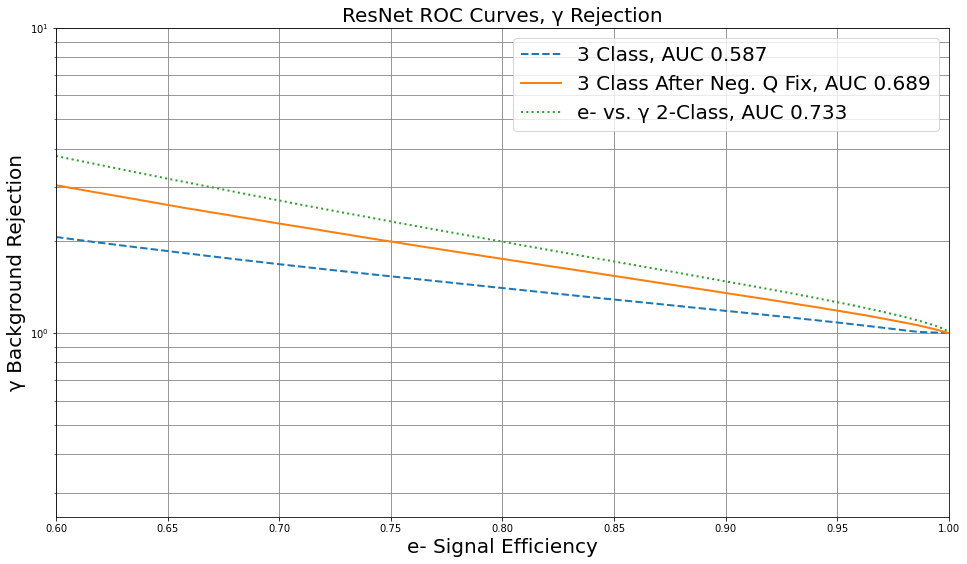

In [7]:
fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "gamma"], 
                                plot_labels=run_names[:3], ax=ax,
                                png_name = 'best_egamma.pdf',title=f"ResNet ROC Curves, {legend_label_dict['gamma']} Rejection",annotate=False,legend_label_dict=legend_label_dict,linestyle=['--','-',':'])
ax.set_xlim(left=0.6,right=1.0)
ax.set_ylim(top=10)

In [8]:
collapsed_3class_scores, collapsed_3class_labels = collapse_test_output(test_output[0]['softmax'],test_output[0]['labels'],
                                                                 softmax_index_dict)
collapsed_3class_labels=collapsed_3class_labels-1
collapsed_3class_scores=collapsed_3class_scores[:,1:]

collapsed_3class_scores2, collapsed_3class_labels2 = collapse_test_output(test_output[1]['softmax'],test_output[1]['labels'],
                                                                 softmax_index_dict)
collapsed_3class_labels2=collapsed_3class_labels2-1
collapsed_3class_scores2=collapsed_3class_scores2[:,1:]

In [15]:
fprs, tprs, thresholds = zip(*[prep_roc_data(collapsed_3class_scores,collapsed_3class_labels,
                                'rejection',muon_softmax_index_dict,"e/gamma","mu"),
                               prep_roc_data(collapsed_3class_scores2,collapsed_3class_labels2,
                                'rejection',muon_softmax_index_dict,"e/gamma","mu"),
                               prep_roc_data(test_output[-1]['softmax'],test_output[-1]['labels'],
                                'rejection',muon_softmax_index_dict,"e/gamma","mu"),
                              ])

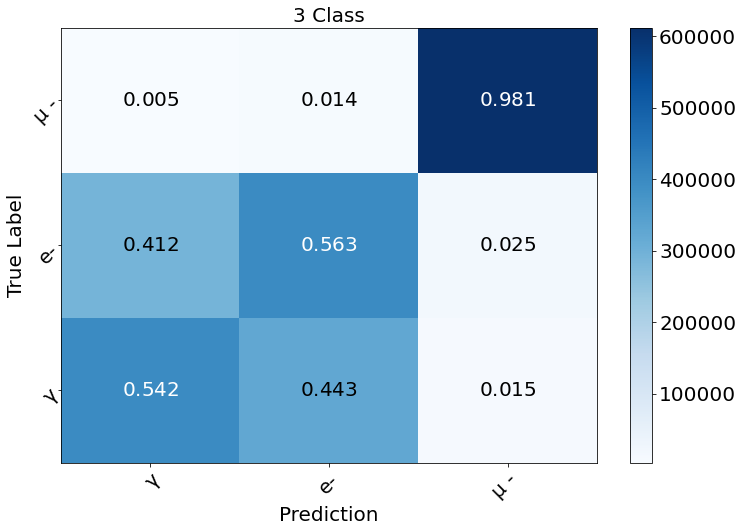

In [16]:
plot_confusion_matrix(test_output[0]['labels'],test_output[0]['predicted_labels'],['\u03B3','e-','\u03BC -'],title=run_names[0])

(0.6, 1.0)

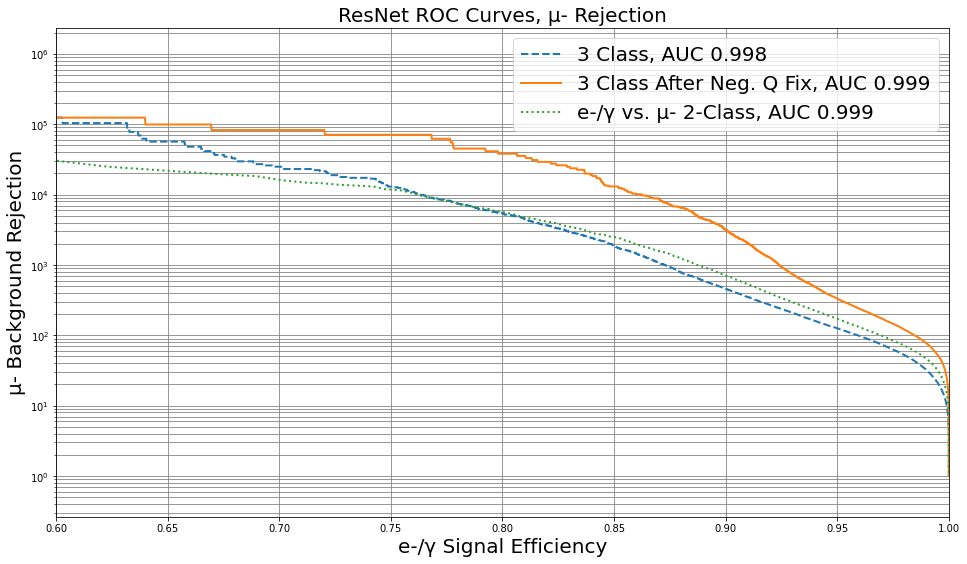

In [18]:
fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e/gamma", "mu"], 
                                plot_labels=[run_names[0],run_names[1],run_names[-1]],
                                ax=ax,png_name='best_emu.pdf',title=f"ResNet ROC Curves, {legend_label_dict['mu']} Rejection",annotate=False,legend_label_dict=muon_legend_label_dict,linestyle=['--','-',':'])
ax.set_xlim(left=0.6,right=1.0)

In [ ]:
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
original_labels = np.array(f['labels'])
#filtered_eventdata = original_eventdata[test_filtered_indices]
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
filtered_energies = original_energies[test_filtered_indices]
filtered_positions = original_positions[test_filtered_indices]
filtered_angles = original_angles[test_filtered_indices]
filtered_labels = original_labels[test_filtered_indices]

In [ ]:
plt.show()
fig, ax = plt.subplots(1,1,figsize=(25,25),facecolor='w')
cmap = plt.cm.viridis
cmap.set_bad(color='black')
event=original_eventdata[np.where(original_labels==0)[0][np.random.randint(1,high=3000000)],:,:,0:19]
a=get_plot_array(event)
ax.imshow(a,
           origin="upper",
           cmap=cmap,
           norm=colors.LogNorm(vmax=np.amax(event),
                                         clip=True))
plt.show()

In [ ]:
plt.show()
fig, ax = plt.subplots(1,1,figsize=(25,25),facecolor='w')
cmap = plt.cm.viridis
cmap.set_bad(color='black')
event=original_eventdata[np.where(original_labels==1)[0][np.random.randint(1,high=3000000)],:,:,0:19]
a=get_plot_array(event)
ax.imshow(a,
           origin="upper",
           cmap=cmap,
           norm=colors.LogNorm(vmax=np.amax(event),
                                         clip=True))
plt.show()

In [ ]:
plt.show()
fig, ax = plt.subplots(1,1,figsize=(25,25),facecolor='w')
cmap = plt.cm.viridis
cmap.set_bad(color='black')
event=original_eventdata[np.where(original_labels==2)[0][np.random.randint(1,high=3000000)],:,:,0:19]
a=get_plot_array(event)
ax.imshow(a,
           origin="upper",
           cmap=cmap,
           norm=colors.LogNorm(vmax=np.amax(event),
                                         clip=True))
plt.show()